In [37]:
%load_ext autoreload
%autoreload 2

from cuadripolos import Cuadripolo 
import numpy as np
from sympy import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Método de resolucón de silenciadores de manera analítica a través cuadripolos. 
silenciador:
- 1 Cámara de expansión
- 2 tubo
- 3 Cámara de expansión 
- 4 
 - 4.1 Extensión expansión
 - 4.2 Resonador de helmholtz

In [70]:
# 1 cámara
camara_s = np.pi*0.126*0.06
camara_s1 = camara_s2 = np.pi*0.02**2
camara_largo = 0.3
# 2 tubo 
tubo_s = tubo_s1 = np.pi*0.02**2
tubo_largo = 0.19 
# 3 camara 
camara_s = np.pi*0.126*0.06
camara_s1 = camara_s2 = np.pi*0.02**2
# 4 resonador + tubo de cuarto de onda: 
    # 4.1 tubo de cuarto de onda: 
tubo_cuarto_s = tubo_cuarto_s1 = np.pi*0.02**2
tubo_cuarto_largo = 0.01
    #4.1 extensión_expansión
exten_expan_s1 = np.pi*0.126*0.06 
exten_expan_s = np.pi*0.02**2
exten_expan_l = 0.01
    #4.2 rezonador de helmholtz 
helmholtz_s = helmholtz_s1 = 0.02**2*np.pi*2
helmholtz_l= 0.01
helmholtz_v = 2*np.pi*0.126*0.06*0.19 - tubo_largo*tubo_s

## Armo los cuadripolos 

In [10]:
#camara
camara = Cuadripolo(s=camara_s, largo=camara_largo, s1=camara_s1, s2=camara_s2, tipo = 'camara')
camara.coeficientes()
camara.obtencion_tl()
camara.plot_tl()

No handles with labels found to put in legend.


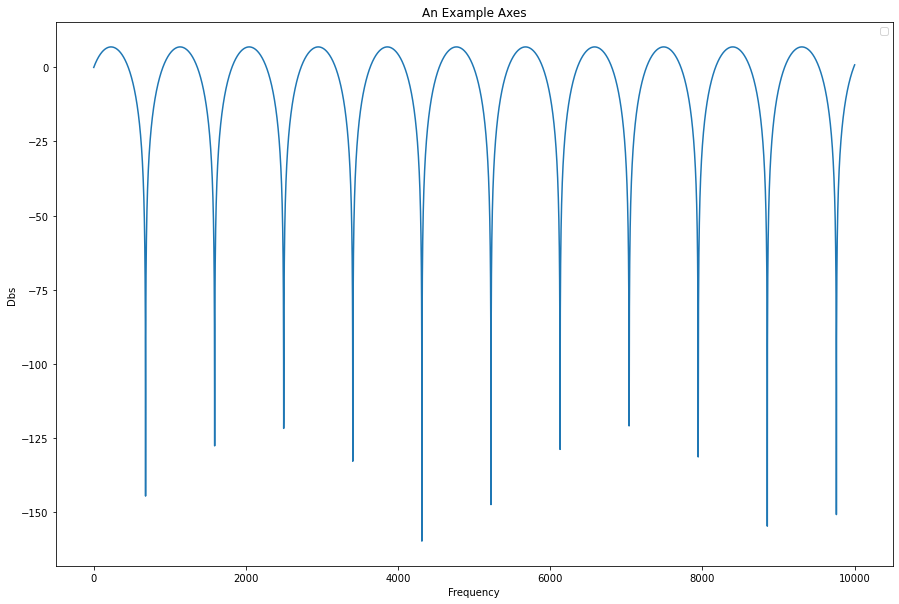

In [13]:
#tubo 
tubo = Cuadripolo(tubo_s, largo = tubo_largo, tipo = 'tubo')
tubo.coeficientes()
tubo.obtencion_tl()
tubo.plot_tl()

In [16]:
#camara 
camara_3 = Cuadripolo(s = camara_s, s1 = camara_s1, s2 = camara_s2, largo = camara_largo, tipo = 'camara')
camara_3.coeficientes()
camara_3.obtencion_tl()
camara_3.plot_tl()

No handles with labels found to put in legend.


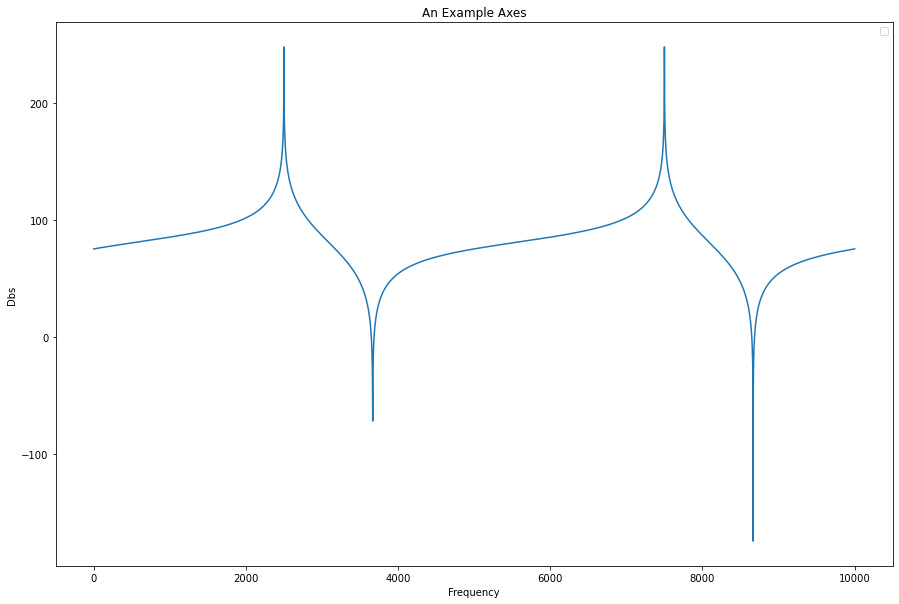

In [69]:
expansion_extension = Cuadripolo(s = exten_expan_s, s1=exten_expan_s1, s2=exten_expan_s, largo=exten_expan_l, tipo = 'extension_expansion')
expansion_extension.coeficientes()
expansion_extension.obtencion_tl()
expansion_extension.plot_tl()

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.


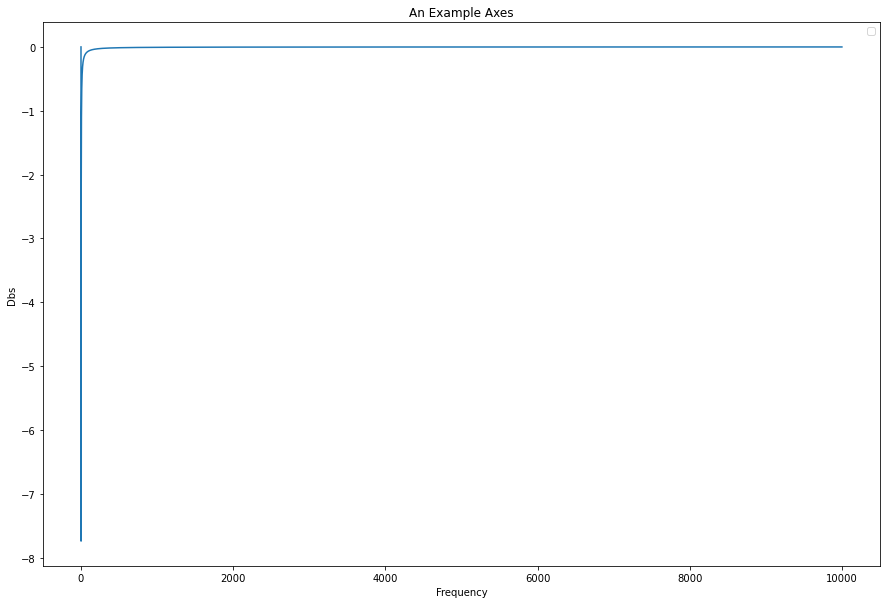

In [82]:
reso = Cuadripolo(s = helmholtz_s, s1 = helmholtz_s1, largo = helmholtz_l, tipo = 'helmholtz', vol = helmholtz_v)
reso.coeficientes()
reso.obtencion_tl()
reso.plot_tl()

In [96]:
componente_4_5 = expansion_extension * reso

In [101]:
componente_4_5.s1 = np.pi*0.02**2

In [111]:
componente_4_5.obtencion_tl()

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.


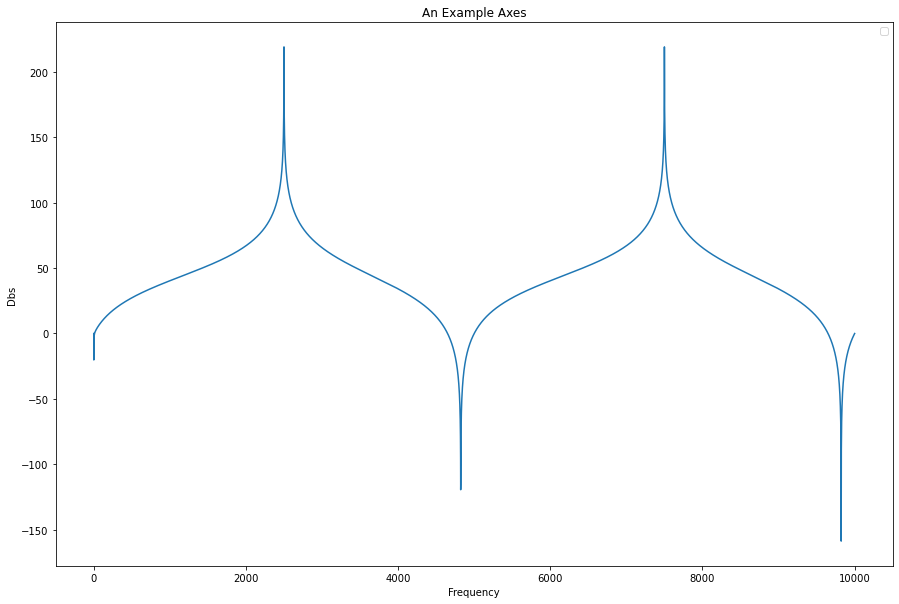

In [112]:
componente_4_5.plot_tl()

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.


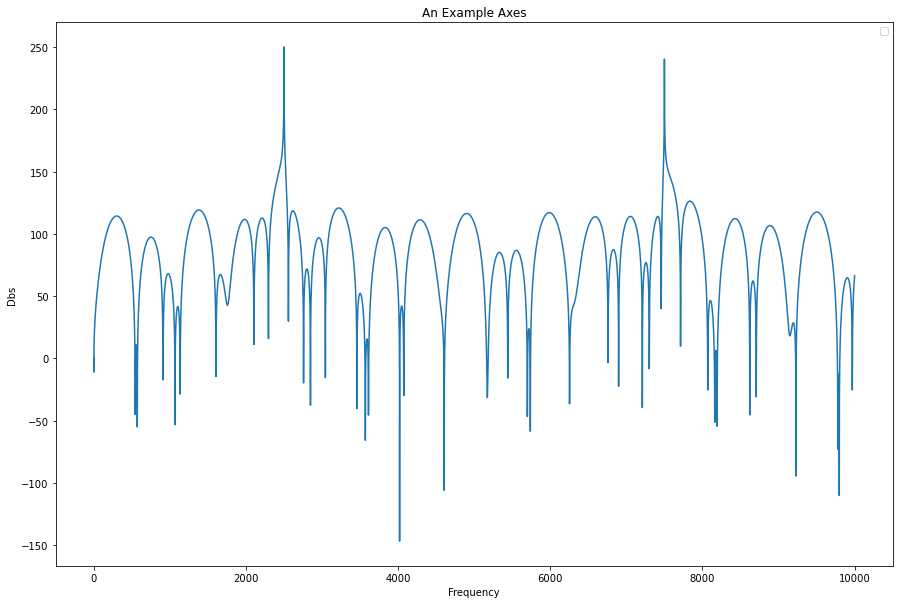

In [118]:
# total 
silenciador_total = camara * tubo * camara_3 * componente_4_5
silenciador_total.s1 = silenciador_total.s2 = np.pi * 0.02 ** 2
silenciador_total.obtencion_tl()
silenciador_total.plot_tl()